In [15]:
import torch
import numpy as np
from tqdm import tqdm
from torchvision import transforms
from skimage import io
import matplotlib.pyplot as plt

def generate_cluster_map(image, vae, kmeans, patch_size=96, resized_size=64, device='cuda'):
    H, W = image.shape

    # Crop image center so H, W are divisible by patch_size
    new_H = (H // patch_size) * patch_size
    new_W = (W // patch_size) * patch_size
    top = (H - new_H) // 2
    left = (W - new_W) // 2
    image = image[top:top + new_H, left:left + new_W]

    grid_H = new_H // patch_size
    grid_W = new_W // patch_size
    cluster_map = np.zeros((grid_H, grid_W), dtype=np.uint8)

    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((resized_size, resized_size)),
    ])

    vae.eval()
    with torch.no_grad():
        for i in tqdm(range(grid_H), desc="Processing rows"):
            for j in range(grid_W):
                patch = image[i * patch_size:(i + 1) * patch_size,
                              j * patch_size:(j + 1) * patch_size]
                patch_tensor = to_tensor(patch).unsqueeze(0).to(device)  # [1, 1, 64, 64]
                _, mu, _ = vae(patch_tensor)
                latent_vec = mu.cpu().numpy()
                cluster_id = kmeans.predict(latent_vec)[0]
                cluster_map[i, j] = cluster_id

    return cluster_map

def save_cluster_map_as_image(cluster_map, out_path, original_image=None):
    from skimage.transform import resize
    vis_map = resize(cluster_map, (cluster_map.shape[0]*96, cluster_map.shape[1]*96), order=0, preserve_range=True).astype(np.uint8)
    io.imsave(out_path, vis_map)

    # Standard visualization
    plt.imshow(cluster_map, cmap='tab10')
    plt.title("Cluster ID Map")
    plt.colorbar(label="Cluster ID")
    plt.axis('off')
    plt.savefig(out_path.replace('.png', '_vis.png'), dpi=300)
    # plt.close()

    # Overlay visualization
    if original_image is not None:
        # Crop original image to match cluster map size
        H, W = original_image.shape
        new_H = (H // 96) * 96
        new_W = (W // 96) * 96
        top = (H - new_H) // 2
        left = (W - new_W) // 2
        cropped_image = original_image[top:top + new_H, left:left + new_W]

        overlay = resize(cluster_map, cropped_image.shape, order=0, preserve_range=True)

        plt.imshow(cropped_image, cmap='gray')
        plt.imshow(overlay, cmap='tab10', alpha=0.5)
        plt.title("Cluster Overlay on Image")
        plt.axis('off')
        plt.savefig(out_path.replace('.png', '_overlay.png'), dpi=300)
        # plt.close()


In [16]:
import torch.nn as nn
# Step 1: Define the Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, latent_dim=8):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.fc_decode(z).view(-1, 128, 8, 8)
        return self.decoder(x), mu, logvar


Processing rows: 100%|██████████| 29/29 [00:02<00:00, 12.18it/s]
/tmp/ipykernel_2579423/1452534260.py:44: UserWarning: /mnt/d/lding/FA/processed_data/FA_ML_Annabel_20250217_correction/eGFP-Zyxin-488_Phalloidin-405_Vinculin-rb0-647_pPaxy31-m-568/cluster_ID/cluster_map.png is a low contrast image
  io.imsave(out_path, vis_map)


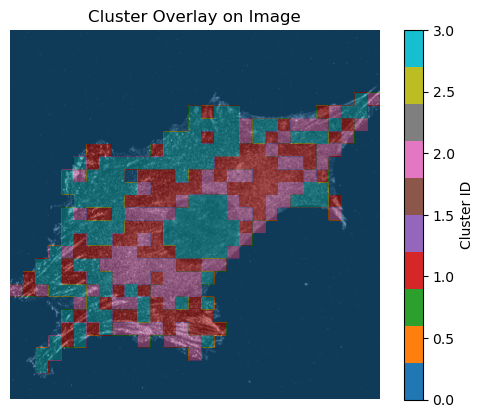

In [17]:

# Load image (assume pre-loaded VAE + KMeans)
image_dir = '/mnt/d/lding/FA/processed_data/FA_ML_Annabel_20250217_correction/eGFP-Zyxin-488_Phalloidin-405_Vinculin-rb0-647_pPaxy31-m-568/Control_again'
image_path = os.path.join(image_dir, 'eGFP-Zyxin 488, Phalloidin 405, Vinculin(rb0) 647, pPaxy31(m)568_control-01_correction.tiff')
output_dir = '/mnt/d/lding/FA/processed_data/FA_ML_Annabel_20250217_correction/eGFP-Zyxin-488_Phalloidin-405_Vinculin-rb0-647_pPaxy31-m-568/cluster_ID'
os.makedirs(output_dir,exist_ok=True)
output_path = os.path.join(output_dir,'cluster_map.png')

image = tiff.imread(image_path)
if image.ndim == 3:
    image = image[0]  # Use first channel if needed
if image.dtype != np.uint8:
    image = (image * 240).astype(np.uint8)

# Load models
vae = torch.load('/mnt/d/lding/FA/analysis_results/panel_annabel_20250217_correction/test/FA_vinculin_vae_model.pt')  # or load state_dict
kmeans_model = joblib.load('/mnt/d/lding/FA/analysis_results/panel_annabel_20250217_correction/test/FA_vinculin_kmeans_latent_model.pkl')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = vae.to(device)

cluster_map = generate_cluster_map(image, vae, kmeans_model, patch_size=64, device=device)
save_cluster_map_as_image(cluster_map, output_path,image)


/tmp/ipykernel_2579423/1452534260.py:44: UserWarning: /mnt/d/lding/FA/processed_data/FA_ML_Annabel_20250217_correction/eGFP-Zyxin-488_Phalloidin-405_Vinculin-rb0-647_pPaxy31-m-568/cluster_ID/cluster_map.png is a low contrast image
  io.imsave(out_path, vis_map)


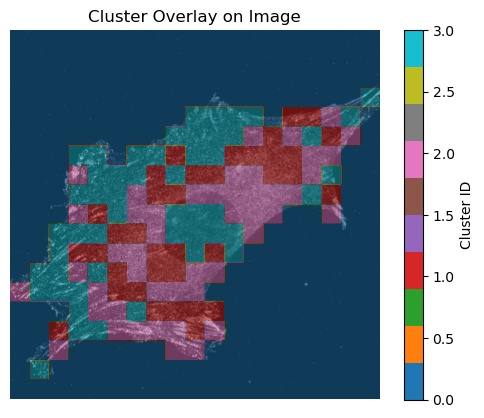

In [14]:
save_cluster_map_as_image(cluster_map, output_path,image)